# fMRI Denoising Demo

This notebook demonstrates the explicit denoising functionality of the fMRI foundation model using the `forward_denoise` method. The denoising approach uses multiple masked reconstructions with partitioned patch masks to separate structured signal from unstructured noise.


## Setup and Imports


In [23]:
import time

import torch
import numpy as np
from matplotlib import pyplot as plt
from huggingface_hub import hf_hub_download

import models_mae
from util.visualization import FC_CMAP

In [24]:
plt.rcParams["figure.dpi"] = 100

## Load Model and Data


In [25]:
# download checkpoint from hugging face hub
print("Downloading checkpoint from Hugging Face...")
checkpoint_path = hf_hub_download(
    repo_id="medarc/fmri-fm",
    filename="checkpoints/fm_mae_pretrain_vit_small.pth",
    repo_type="dataset",
)

# load a pretrained checkpoint for a ViT-S/16
ckpt = torch.load(checkpoint_path, weights_only=True)

args = ckpt["args"]
state = ckpt["model"]

model = models_mae.__dict__[args["model"]](**args)
model.load_state_dict(state)
print("Model loaded successfully!")

img_size (224, 560) patch_size (16, 16) frames 16 t_patch_size 16
model initialized
Model loaded successfully!


In [26]:
# Load real data from Hugging Face - direct approach
print("Downloading sample data from Hugging Face...")

try:
    # Download one file from the hcp-train-task-clips-16t directory
    from huggingface_hub import list_repo_files

    # List files in the hcp-train-task-clips-16t directory
    files = list_repo_files("medarc/fmri-fm", repo_type="dataset")
    hcp_files = [
        f
        for f in files
        if f.startswith("datasets/flat-clips/hcp-train-task-clips-16t/")
        and f.endswith(".pt")
    ]

    if hcp_files:
        print(f"Found {len(hcp_files)} HCP clip files")
        print(f"First few files: {hcp_files[:3]}")

        # Download the first file
        first_file = hcp_files[0]
        print(f"Downloading: {first_file}")

        file_path = hf_hub_download(
            repo_id="medarc/fmri-fm", filename=first_file, repo_type="dataset"
        )

        # Load the .pt file directly
        sample = torch.load(file_path, weights_only=True)
        print(f"Loaded sample with keys: {sample.keys()}")

        # Extract images and add channel dimension if needed
        images = sample["image"]
        print(f"Original image shape: {images.shape}")

        # Ensure we have the right shape: (N, C, T, H, W)
        if len(images.shape) == 4:  # (T, H, W) - missing batch and channel
            images = images.unsqueeze(0).unsqueeze(0)  # Add batch and channel dims
        elif len(images.shape) == 3:  # (T, H, W) - missing batch and channel
            images = images.unsqueeze(0).unsqueeze(0)  # Add batch and channel dims

        print(f"Final image shape: {images.shape}")

        # Create a patch-level mask from the image data (non-zero values are valid)
        # The mask should be at patch resolution for the forward_denoise function
        # Calculate patch dimensions: H_patches = H // patch_size, W_patches = W // patch_size
        patch_size = 16  # This should match the model's patch_size
        H_patches = images.shape[3] // patch_size  # 224 // 16 = 14
        W_patches = images.shape[4] // patch_size  # 560 // 16 = 35

        # Create patch-level mask by checking if patches contain non-zero values
        img_pixel_mask = (images[0, 0, 0] != 0).float()  # first frame
        img_mask = torch.zeros(H_patches, W_patches)
        for i in range(H_patches):
            for j in range(W_patches):
                h_start, h_end = i * patch_size, (i + 1) * patch_size
                w_start, w_end = j * patch_size, (j + 1) * patch_size
                patch_region = img_pixel_mask[h_start:h_end, w_start:w_end]
                img_mask[i, j] = 1.0 if patch_region.sum() > 0 else 0.0

        print(f"Created patch-level mask shape: {img_mask.shape}")

        print("Successfully loaded real HCP data!")
        print(f"Sample key: {sample.get('__key__', 'unknown')}")
        print(f"Subject: {sample.get('sub', 'unknown')}")
        print(f"Task: {sample.get('task', 'unknown')}")

    else:
        raise ValueError("No HCP clip files found")

except Exception as e:
    print(f"Failed to load real data: {e}")
    print("Using synthetic data for demo...")

    # Fallback to synthetic data with correct 5D shape
    images = torch.randn(1, 1, 16, 224, 560) * 0.5  # (N, C, T, H, W)

    # Create patch-level mask for synthetic data
    patch_size = 16
    H_patches = 224 // patch_size  # 14
    W_patches = 560 // patch_size  # 35
    img_mask = torch.ones(H_patches, W_patches)  # All patches valid for synthetic data

    sample = {"image": images, "mask": img_mask, "__key__": "synthetic_demo"}

print(f"Final data shape - Images: {images.shape}, Mask: {img_mask.shape}")

Found 100 HCP clip files
First few files: ['datasets/flat-clips/hcp-train-task-clips-16t/0000000.pt', 'datasets/flat-clips/hcp-train-task-clips-16t/0000001.pt', 'datasets/flat-clips/hcp-train-task-clips-16t/0000002.pt']
Downloading: datasets/flat-clips/hcp-train-task-clips-16t/0000000.pt
Loaded sample with keys: dict_keys(['__key__', 'sub', 'mod', 'task', 'mag', 'dir', 'n_frames', 'image', 'start', 'onset', 'duration', 'trial_type', 'target'])
Original image shape: torch.Size([16, 224, 560])
Final image shape: torch.Size([1, 1, 16, 224, 560])
Created patch-level mask shape: torch.Size([14, 35])
Successfully loaded real HCP data!
Sample key: sub-349244_mod-tfMRI_task-RELATIONAL_mag-3T_dir-RL
Subject: 349244
Task: RELATIONAL
Final data shape - Images: torch.Size([1, 1, 16, 224, 560]), Mask: torch.Size([14, 35])


## Basic Denoising Demo


In [27]:
# set up generator for reproducibility
generator = torch.Generator()
generator.manual_seed(42)

# run denoising with default parameters
print("Running denoising...")
start_time = time.time()

denoised_images = model.forward_denoise(
    images,  # already has batch dimension
    mask_ratio=0.75,
    n_samples=4,
    img_mask=img_mask,  # use the patch-level mask we created
    generator=generator,
)

end_time = time.time()
print(f"Denoising completed in {end_time - start_time:.2f} seconds")
print(f"Original shape: {images.shape}")
print(f"Denoised shape: {denoised_images.shape}")

Running denoising...
Denoising completed in 0.37 seconds
Original shape: torch.Size([1, 1, 16, 224, 560])
Denoised shape: torch.Size([1, 1, 8, 224, 560])


## Visualization: Original vs Denoised


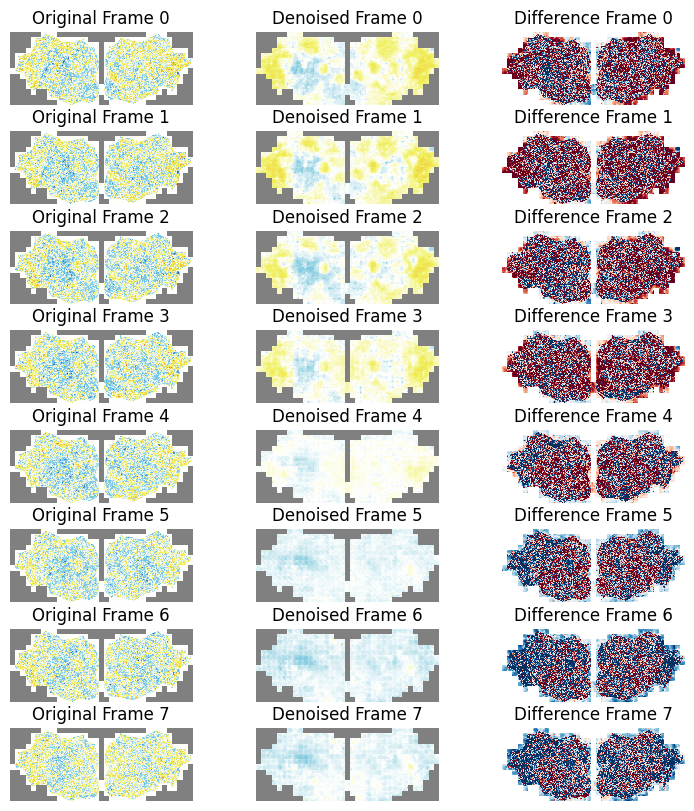

In [28]:
# visualize original and denoised images side by side
# images shape: [N, C, T, H, W] = [1, 1, 16, 224, 560]
# denoised_images shape: [N, C, T, H, W] = [1, 1, 8, 224, 560]

# Fix: Get spatial dimensions correctly from 5D tensor
H, W = images.shape[3:5]  # Get spatial dimensions (224, 560)
ploth = 1.0
plotw = (W / H) * ploth

# Convert patch-level mask to pixel-level mask for visualization
patch_size = 16  # This should match the model's patch_size
H_patches, W_patches = img_mask.shape  # (14, 35)
pixel_mask = np.zeros((H, W))  # (224, 560)

# Expand patch-level mask to pixel-level
for i in range(H_patches):
    for j in range(W_patches):
        h_start, h_end = i * patch_size, (i + 1) * patch_size
        w_start, w_end = j * patch_size, (j + 1) * patch_size
        pixel_mask[h_start:h_end, w_start:w_end] = img_mask[i, j].numpy()

# Use the smaller number of frames for visualization
n_frames = min(images.shape[2], denoised_images.shape[2])  # min(16, 8) = 8
nr = n_frames
nc = 3  # original, denoised, difference

f, axs = plt.subplots(nr, nc, figsize=(nc * plotw, nr * ploth))
axs = axs.flatten()

for ii in range(nr):
    # original image
    ax_idx = ii * 3
    plt.sca(axs[ax_idx])
    img = np.where(pixel_mask > 0, images[0, 0, ii].numpy(), np.nan)
    plt.imshow(img, vmin=-3, vmax=3, cmap=FC_CMAP, interpolation="none")
    plt.title(f"Original Frame {ii}")
    plt.axis("off")

    # denoised image
    plt.sca(axs[ax_idx + 1])
    img_denoised = np.where(pixel_mask > 0, denoised_images[0, 0, ii].numpy(), np.nan)
    plt.imshow(img_denoised, vmin=-3, vmax=3, cmap=FC_CMAP, interpolation="none")
    plt.title(f"Denoised Frame {ii}")
    plt.axis("off")

    # difference
    plt.sca(axs[ax_idx + 2])
    diff = np.where(
        pixel_mask > 0,
        denoised_images[0, 0, ii].numpy() - images[0, 0, ii].numpy(),
        np.nan,
    )
    plt.imshow(diff, vmin=-0.5, vmax=0.5, cmap="RdBu_r", interpolation="none")
    plt.title(f"Difference Frame {ii}")
    plt.axis("off")

plt.tight_layout(pad=0.3)

## Parameter Exploration

Let's test how different parameters affect the denoising quality and speed:


In [29]:
# test different n_samples values
n_samples_to_test = [1, 2, 4, 8]
results = {}

for n_samples in n_samples_to_test:
    print(f"Testing n_samples = {n_samples}")
    start_time = time.time()

    denoised = model.forward_denoise(
        images,  # images already has the correct shape [1, 1, 16, 224, 560]
        mask_ratio=0.75,
        n_samples=n_samples,
        img_mask=img_mask,  # img_mask already has the correct shape [14, 35]
        generator=generator,
    )

    end_time = time.time()
    results[n_samples] = {"denoised": denoised, "time": end_time - start_time}
    print(f"  Completed in {end_time - start_time:.2f} seconds")

print("\nResults summary:")
for n_samples, result in results.items():
    print(f"n_samples={n_samples}: {result['time']:.2f}s")

Testing n_samples = 1
  Completed in 0.19 seconds
Testing n_samples = 2
  Completed in 0.19 seconds
Testing n_samples = 4
  Completed in 0.25 seconds
Testing n_samples = 8
  Completed in 0.41 seconds

Results summary:
n_samples=1: 0.19s
n_samples=2: 0.19s
n_samples=4: 0.25s
n_samples=8: 0.41s


In [30]:
# test different mask_ratio values
mask_ratios_to_test = [0.5, 0.75, 0.9]
mask_results = {}

for mask_ratio in mask_ratios_to_test:
    print(f"Testing mask_ratio = {mask_ratio}")
    start_time = time.time()

    denoised = model.forward_denoise(
        images,
        mask_ratio=mask_ratio,
        n_samples=4,  # fixed n_samples for fair comparison
        img_mask=img_mask,
        generator=generator,
    )

    end_time = time.time()
    mask_results[mask_ratio] = {"denoised": denoised, "time": end_time - start_time}
    print(f"  Completed in {end_time - start_time:.2f} seconds")

print("\nMask ratio results summary:")
for mask_ratio, result in mask_results.items():
    print(f"mask_ratio={mask_ratio}: {result['time']:.2f}s")

Testing mask_ratio = 0.5
  Completed in 0.38 seconds
Testing mask_ratio = 0.75
  Completed in 0.26 seconds
Testing mask_ratio = 0.9
  Completed in 0.23 seconds

Mask ratio results summary:
mask_ratio=0.5: 0.38s
mask_ratio=0.75: 0.26s
mask_ratio=0.9: 0.23s


## Quality Assessment

Let's compare the denoising quality across different parameters:


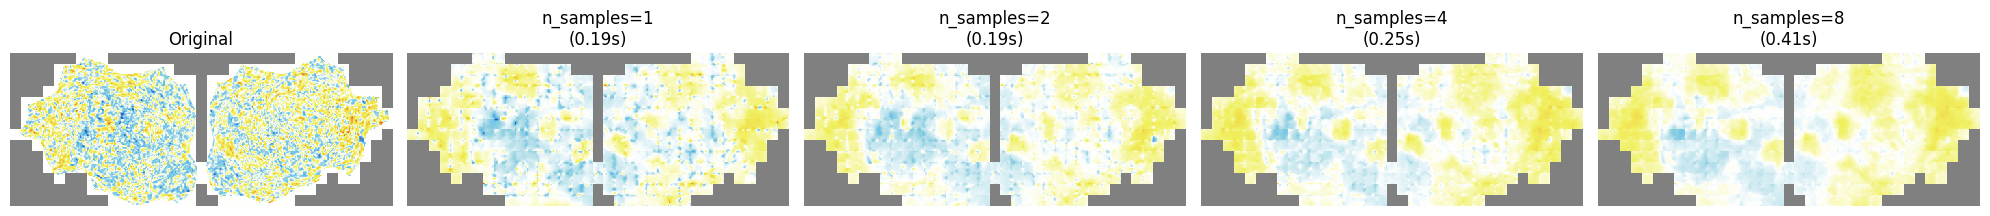

In [31]:
# compare denoising quality across different n_samples
# Create grid with exact number of plots needed: 1 original + 4 n_samples = 5 total
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

# show original for reference
plt.sca(axes[0])
img = np.where(pixel_mask > 0, images[0, 0, 0].numpy(), np.nan)
plt.imshow(img, vmin=-3, vmax=3, cmap=FC_CMAP, interpolation="none")
plt.title("Original")
plt.axis("off")

# show denoised results for different n_samples
for i, (n_samples, result) in enumerate(results.items()):
    plt.sca(axes[i + 1])
    img_denoised = np.where(pixel_mask > 0, result["denoised"][0, 0, 0].numpy(), np.nan)
    plt.imshow(img_denoised, vmin=-3, vmax=3, cmap=FC_CMAP, interpolation="none")
    plt.title(f"n_samples={n_samples}\n({result['time']:.2f}s)")
    plt.axis("off")

plt.tight_layout()

In [32]:
# calculate and compare noise reduction metrics
def calculate_noise_metrics(original, denoised, mask):
    """Calculate noise reduction metrics"""
    # only consider valid regions
    valid_original = original[mask > 0]
    valid_denoised = denoised[mask > 0]

    # calculate standard deviation (noise level)
    orig_std = np.std(valid_original)
    denoised_std = np.std(valid_denoised)

    # calculate noise reduction ratio
    noise_reduction = (orig_std - denoised_std) / orig_std * 100

    return {
        "original_std": orig_std,
        "denoised_std": denoised_std,
        "noise_reduction_pct": noise_reduction,
    }


print("=== Noise Reduction Analysis ===")
print(
    f"{'n_samples':<10} {'Original Std':<12} {'Denoised Std':<12} {'Noise Reduction':<15}"
)
print("-" * 55)

for n_samples, result in results.items():
    metrics = calculate_noise_metrics(
        images[0, 0, 0].numpy(),
        result["denoised"][0, 0, 0].numpy(),
        pixel_mask,  # Use pixel-level mask instead of patch-level
    )
    print(
        f"{n_samples:<10} {metrics['original_std']:<12.4f} {metrics['denoised_std']:<12.4f} {metrics['noise_reduction_pct']:<15.1f}%"
    )

=== Noise Reduction Analysis ===
n_samples  Original Std Denoised Std Noise Reduction
-------------------------------------------------------
1          0.6426       0.3806       40.8           %
2          0.6426       0.3213       50.0           %
4          0.6426       0.3298       48.7           %
8          0.6426       0.3141       51.1           %


## Temporal Consistency

Let's examine how well the denoising preserves temporal structure:


/Users/harshilshah/Desktop/fmri-fm/.venv/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


Temporal consistency (autocorrelation):
  Original:  0.2964
  Denoised:  0.5592
  Change:    +0.2628


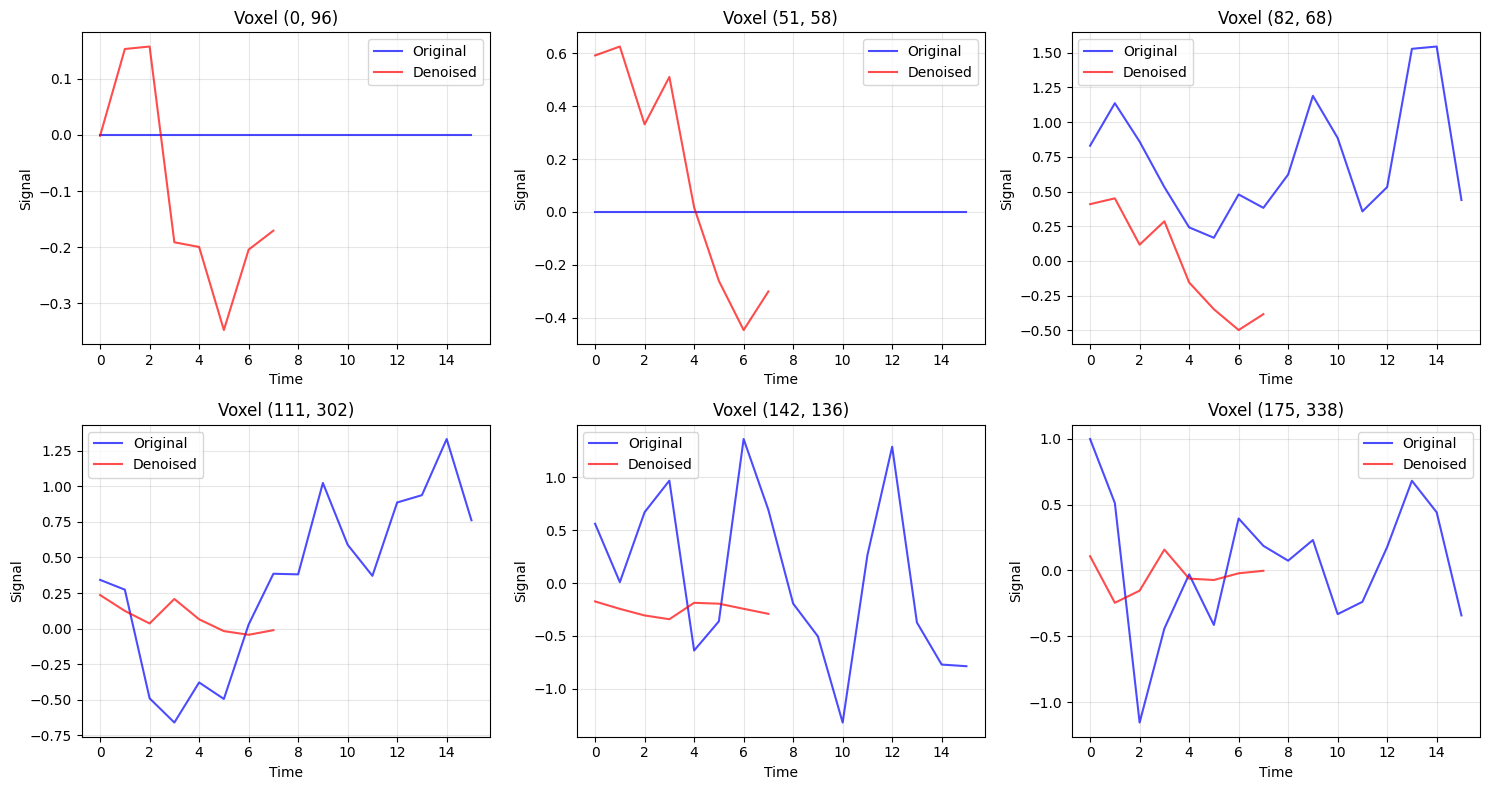

In [33]:
# analyze temporal consistency
def calculate_temporal_consistency(data, mask):
    """Calculate temporal consistency metrics"""
    # get valid voxels
    valid_mask = mask > 0

    # calculate temporal correlation for each valid voxel
    correlations = []
    for i in range(data.shape[1]):  # height
        for j in range(data.shape[2]):  # width
            if valid_mask[i, j]:
                # get time series for this voxel
                time_series = data[:, i, j]
                if len(time_series) > 1:
                    # calculate autocorrelation (lag-1)
                    corr = np.corrcoef(time_series[:-1], time_series[1:])[0, 1]
                    if not np.isnan(corr):
                        correlations.append(corr)

    return np.mean(correlations) if correlations else 0.0


# calculate temporal consistency for original and denoised data
original_consistency = calculate_temporal_consistency(images[0, 0].numpy(), pixel_mask)

denoised_consistency = calculate_temporal_consistency(
    denoised_images[0, 0].numpy(), pixel_mask
)

print("Temporal consistency (autocorrelation):")
print(f"  Original:  {original_consistency:.4f}")
print(f"  Denoised:  {denoised_consistency:.4f}")
print(f"  Change:    {denoised_consistency - original_consistency:+.4f}")

# plot temporal profiles for a few voxels
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

# select some interesting voxels to plot
valid_indices = np.where(pixel_mask > 0)
selected_voxels = [
    (valid_indices[0][i], valid_indices[1][i])
    for i in range(0, len(valid_indices[0]), len(valid_indices[0]) // 6)
]

for i, (h, w) in enumerate(selected_voxels[:6]):
    plt.sca(axes[i])

    # plot original and denoised time series
    orig_ts = images[0, 0, :, h, w].numpy()
    denoised_ts = denoised_images[0, 0, :, h, w].numpy()

    plt.plot(orig_ts, "b-", label="Original", alpha=0.7)
    plt.plot(denoised_ts, "r-", label="Denoised", alpha=0.7)
    plt.title(f"Voxel ({h}, {w})")
    plt.xlabel("Time")
    plt.ylabel("Signal")
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()